# PINN Testing

In [13]:
import os
from dotenv import load_dotenv
import sys

In [14]:
load_dotenv()

lib_dir = os.environ.get("LOCAL_LIB_DIR")
sys.path.append(lib_dir)

data_dir_airfoil = os.environ.get("LOCAL_DATA_DIR_AIRFOIL")
model_dir_airfoil = os.path.join(data_dir_airfoil, "models")

In [15]:
import numpy as np
import torch
import yaml
from airfoil_pinn import AirfoilPINN
from naca4digit_airfoil import Naca4DigitAirfoil
from matplotlib import pyplot as plt

In [16]:
with open("config_airfoil.yaml", 'r') as file:
    config = yaml.safe_load(file)

In [17]:
device = torch.device("cpu")

In [18]:
# Define airfoil parameters (example: NACA 2412)
chord = 1.0
m = 0.02  # maximum camber
p = 0.4   # position of maximum camber
t = 0.12  # maximum thickness
num_points = 100

airfoil = Naca4DigitAirfoil(chord, m, p, t)

# testing domain
x_min = config["x_min"]
y_min = config["y_min"]
x_max = config["x_max"]
y_max = config["y_max"]

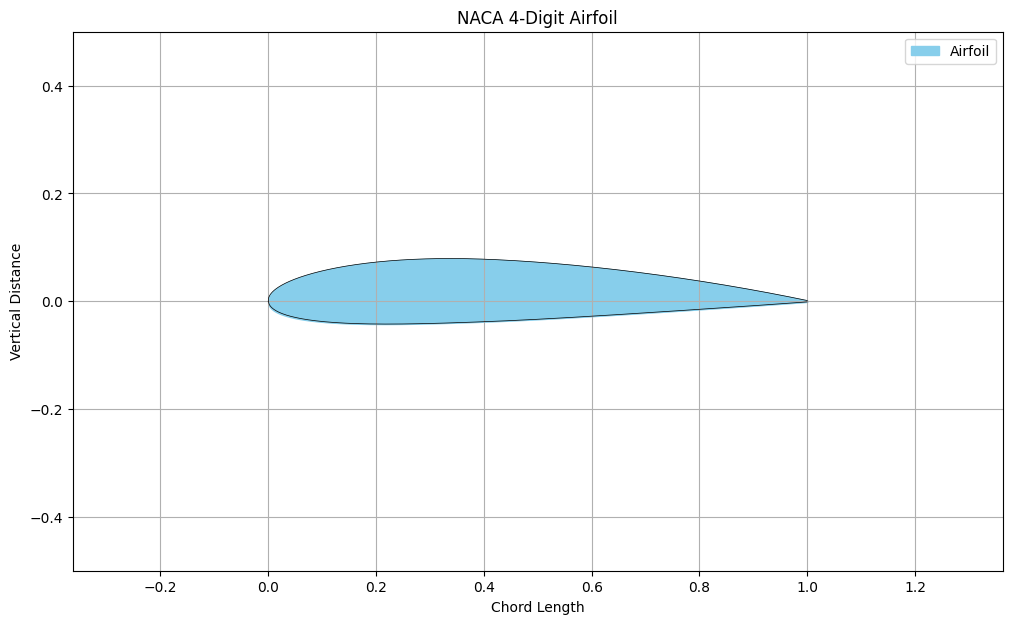

In [19]:
def show_airfoil():
  fig, ax = plt.subplots(figsize=(12, 7))
  airfoil.plot(ax=ax)
  ax.set_xlim(x_min, x_max)
  ax.set_ylim(y_min, y_max)
  plt.show()

show_airfoil()

In [20]:
# load model
model_name = config["model_name"]
model_checkpoint_num = config["model_checkpoint_num"]

pinn = AirfoilPINN.load_from_checkpoint_for_testing(model_dir_airfoil, model_name, model_checkpoint_num).to(device)

=> loading checkpoint '/Users/ggito/repos/pinns/data/airfoil/models/VortexAccuratePioneer189/400.pt'
=> loaded checkpoint '/Users/ggito/repos/pinns/data/airfoil/models/VortexAccuratePioneer189/400.pt' (epoch 400)


In [21]:
Nx = config["Nx"]
Ny = config["Ny"]

dx = x_max / (Nx - 1)
dy = y_max / (Ny - 1)

x_test = np.linspace(x_min, x_max, Nx)
y_test = np.linspace(y_min, y_max, Ny)

X, Y = np.meshgrid(x_test, y_test)

X_flat = X.flatten()
Y_flat = Y.flatten()

input = np.vstack([X_flat, Y_flat]).T

input_tensor = torch.tensor(input, dtype=torch.float32)

input_tensor = input_tensor.to(device)
output_uvp = pinn(input_tensor)

u_test = output_uvp[:, 0].to("cpu").detach().numpy()
v_test = output_uvp[:, 1].to("cpu").detach().numpy()
p_test = output_uvp[:, 2].to("cpu").detach().numpy()

velocity_norm = np.linalg.norm([u_test, v_test], axis=0)

# min & max values of the model outputs
velocity_norm = np.array(velocity_norm)
min_velocity_norm = velocity_norm.min()
max_velocity_norm = velocity_norm.max()

min_pressure = np.array(p_test).min()
max_pressure = np.array(p_test).max()

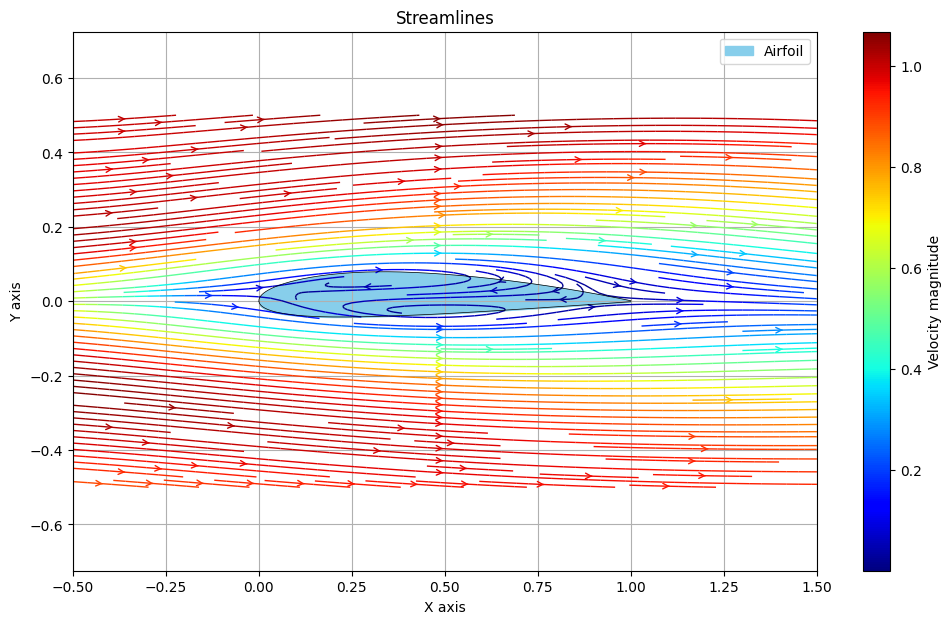

In [22]:
X, Y = np.meshgrid(x_test, y_test)

U = u_test.reshape(Nx, Ny)
V = v_test.reshape(Nx, Ny)

N = velocity_norm.reshape(Nx, Ny)

fig, ax = plt.subplots(figsize=(12, 7))

strm = ax.streamplot(X, Y, U, V, color=N, linewidth=1, cmap='jet', density=2, arrowstyle='->', arrowsize=1)

airfoil.plot(ax=ax)

fig.colorbar(strm.lines, ax=ax, label='Velocity magnitude')

ax.set_title('Streamlines')
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

plt.show()

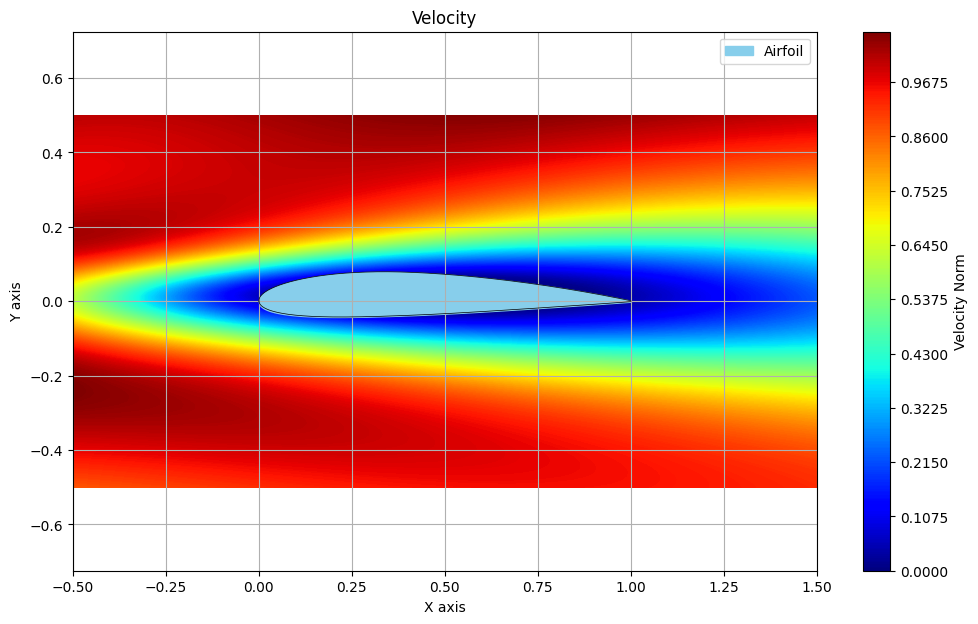

In [23]:
X, Y = np.meshgrid(x_test, y_test)

N = velocity_norm.reshape(Nx, Ny)

fig, ax = plt.subplots(figsize=(12, 7))

contour = ax.contourf(X, Y, N, levels=500, cmap='jet')

plt.colorbar(contour, ax=ax, label='Velocity Norm')

airfoil.plot(ax=ax)

ax.set_title('Velocity')
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.legend()

plt.show()

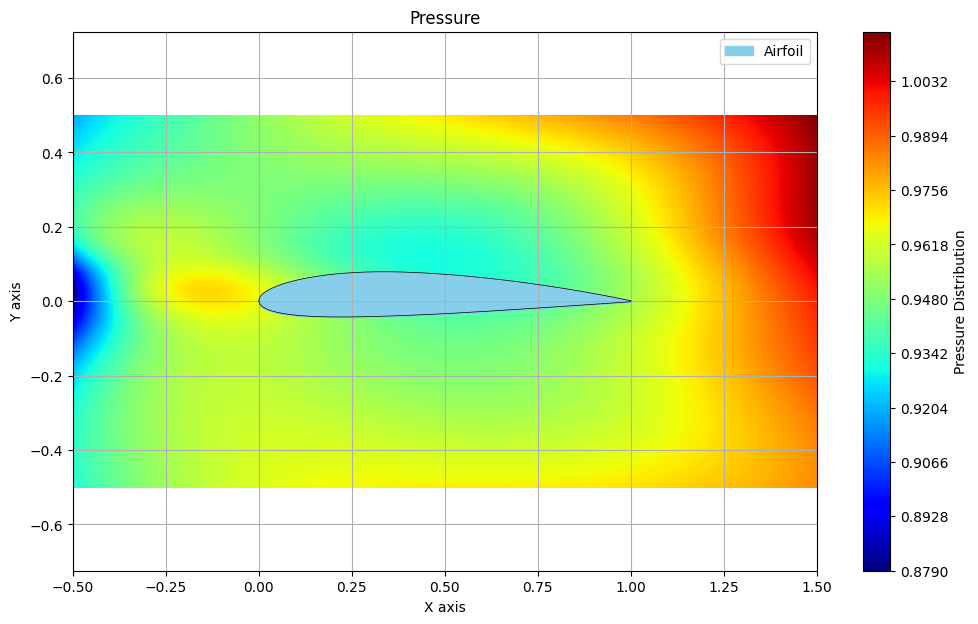

In [24]:
X, Y = np.meshgrid(x_test, y_test)

P = p_test.reshape(Nx, Ny)

fig, ax = plt.subplots(figsize=(12, 7))

contour = ax.contourf(X, Y, P, levels=500, cmap='jet')

plt.colorbar(contour, ax=ax, label='Pressure Distribution')

airfoil.plot(ax=ax)

ax.set_title('Pressure')
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.legend()

plt.show()